# Capstone Project - The Battle of Neighborhoods (Week 1)

The main objective is to do a study of the neighborhoods in New York City and recommend where is the best place to open a new chinese Restaurant.

## Part 1: Define de New York Dataset

In [6]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import os
import folium # map rendering library

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [7]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [8]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'JBSSK1LVMH5GFGMULQUK0CTRI3UBKGNEPXOE5VMKZ315DODH'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='2420XVZ2LHZ3QZSXNJDIA3PPT015RQE4ZLQVGCQEDU1BND1O' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

In [9]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'JBSSK1LVMH5GFGMULQUK0CTRI3UBKGNEPXOE5VMKZ315DODH'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='2420XVZ2LHZ3QZSXNJDIA3PPT015RQE4ZLQVGCQEDU1BND1O' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [11]:
new_york_data=get_new_york_data()

In [12]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
new_york_data.shape

(306, 4)

In [ ]:
There are a total of 306 different Neighborhoods in New York.

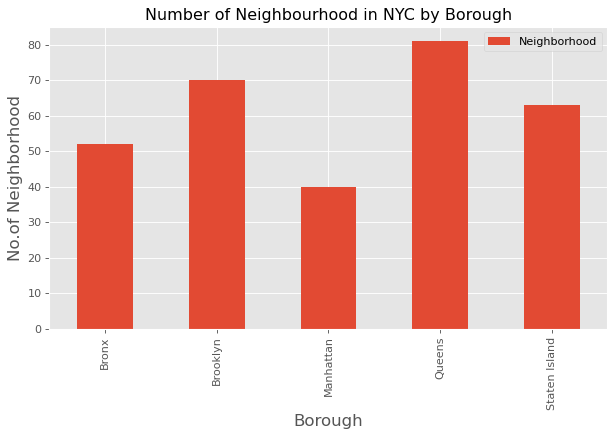

In [14]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
plt.title('Number of Neighbourhood in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

Queens is the most densely populated borough in New York City with around 80 neighborhoods.

## Part 2: Study of teh neighborhood list with Chinese Restaurants

In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:2
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:2
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:4
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:1
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:3
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:2
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

In [17]:
chinese_rest_ny.shape

(409, 4)

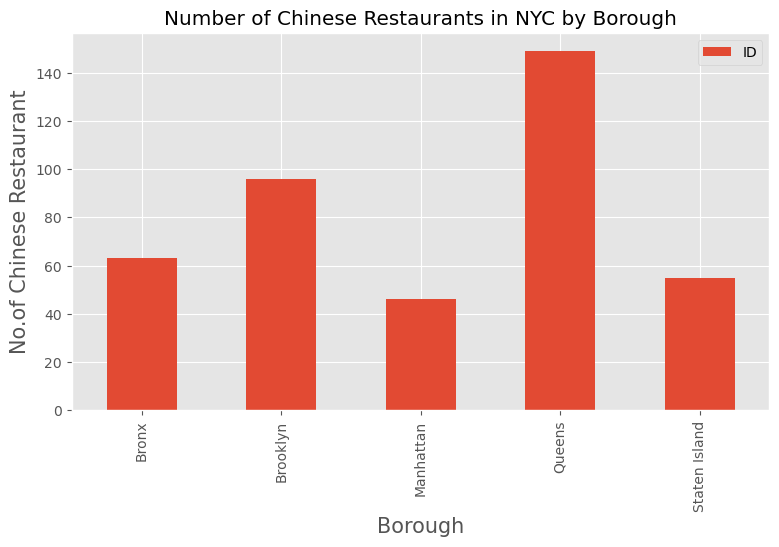

In [20]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Chinese Restaurants in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Restaurant', fontsize=15)
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

Queens is the Borough with more Chinese Restaurants.

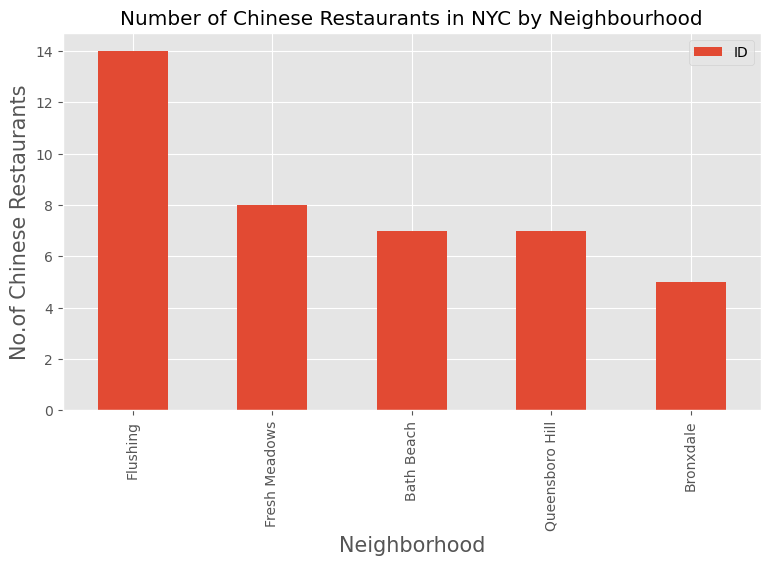

In [21]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Chinese Restaurants in NYC by Neighbourhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Chinese Restaurants', fontsize=15)

chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()

plt.show()

And Flushing is the Neighborhood with more number of Chinese Restaurants

## Part 3: Prepare neighborhood list with the Chinese Restaurants in it with info about them provided by customers.

In [22]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
        
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b897beff964a520c43a32e3
( 2 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 3 / 409 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     5.2    10
( 4 / 409 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4dabc3dc93a04642f09ccabd  Xing Lung Chinese Restaurant      6     6.7     0
( 5 / 409 ) processed
                         ID                           Name  Likes  Rating  \
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese Restaurant      4     7.8   

   Tips  
0     5  
( 6 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, 

In [23]:
chinese_rest_stats_ny.shape

(409, 7)

In [42]:
chinese_rest_ny.shape

(409, 4)

In [43]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

In [44]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [45]:
chinese_rest_stats_ny_csv.shape

(409, 7)

In [46]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0.0,0.0,0.0
1,Bronx,Wakefield,0,0,0.0,0.0,0.0
2,Bronx,Co-op City,0,0,0.0,0.0,0.0
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7.0,5.2,10.0
4,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,6.0,6.7,0.0


In [47]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       409 non-null    object 
 1   Neighborhood  409 non-null    object 
 2   ID            409 non-null    object 
 3   Name          409 non-null    object 
 4   Likes         409 non-null    float64
 5   Rating        409 non-null    object 
 6   Tips          409 non-null    float64
dtypes: float64(2), object(5)
memory usage: 22.5+ KB


In [48]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')

In [49]:
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')

In [50]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       409 non-null    object 
 1   Neighborhood  409 non-null    object 
 2   ID            409 non-null    object 
 3   Name          409 non-null    object 
 4   Likes         409 non-null    float64
 5   Rating        409 non-null    object 
 6   Tips          409 non-null    float64
dtypes: float64(2), object(5)
memory usage: 22.5+ KB


In [51]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]  # ----- Chinese Restaurant with maximum likes

Borough                            Bronx
Neighborhood                     Fordham
ID              566f33e7498e44c2501bda81
Name                       Panda Express
Likes                                 12
Rating                               7.5
Tips                                   2
Name: 22, dtype: object

In [53]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny_csv['Rating'].idxmax()]  # ----- Chinese Restaurant with maximum Rating

Borough                             Manhattan
Neighborhood                      Marble Hill
ID                   4d965fd061a3a1cde4989a42
Name            Lucky Star Chinese Restaurant
Likes                                       4
Rating                                    7.8
Tips                                        5
Name: 5, dtype: object

In [54]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()] # ----- Chinese Restaurant with maximum Rating

Borough                            Bronx
Neighborhood                  Co-op City
ID              4c66dcfaaebea593955a74d0
Name                      Chinese Buffet
Likes                                  7
Rating                               5.2
Tips                                  10
Name: 3, dtype: object

In [56]:
ny_neighborhood_stats=chinese_rest_stats_ny_csv.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [57]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
110,Marble Hill,7.800
66,Fordham,7.500
54,Eastchester,6.700
33,City Island,6.300
129,North Riverdale,5.950
10,Bedford Park,4.300
181,Unionport,3.550
40,Concourse,3.500
131,Norwood,3.225
38,Co-op City,2.600


In [59]:
ny_borough_stats=chinese_rest_stats_ny_csv.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [60]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,1.569841
2,Manhattan,0.169565
1,Brooklyn,0.000000
3,Queens,0.000000
4,Staten Island,0.000000


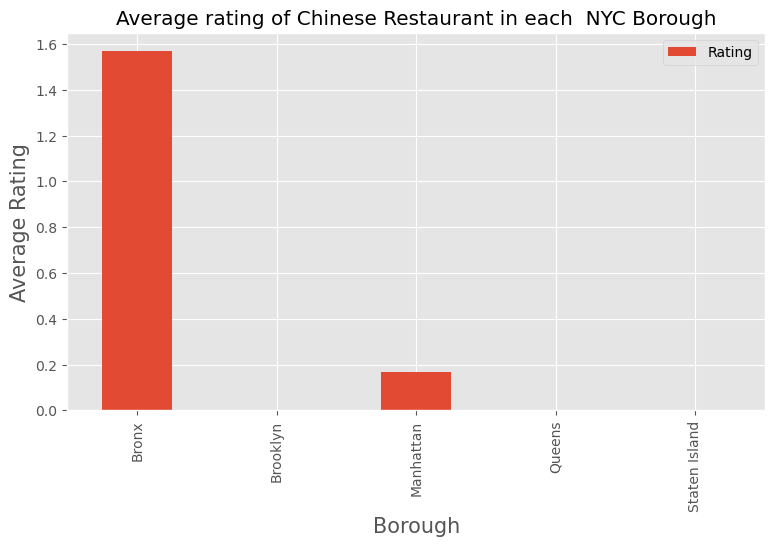

In [62]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurant in each  NYC Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny_csv.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

Bronx borough is the one with higher rating for Chinese restaurant, but not data info from the rest of the neighborhoods should be consider.

In [98]:
ny_neighborhood_stats=chinese_rest_stats_ny_csv[chinese_rest_stats_ny_csv['Rating']>=7.0]

In [99]:
ny_neighborhood_stats 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
5,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,4.0,7.8,5.0
12,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10.0,7.7,10.0
22,Bronx,Fordham,566f33e7498e44c2501bda81,Panda Express,12.0,7.5,2.0
33,Bronx,Parkchester,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0
44,Bronx,Concourse,4d9a695ee5fd6ea8e3096df5,Lucky House Chinese Restaurant,5.0,7.0,2.0
46,Bronx,Unionport,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0


In [100]:
new_york_data.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [101]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats, new_york_data, on='Neighborhood')
ny_neighborhood_stats

,Borough_x,Neighborhood,ID,Name,Likes,Rating,Tips,Borough_y,Latitude,Longitude
0,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,4.0,7.8,5.0,Manhattan,40.876551,-73.910660
1,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10.0,7.7,10.0,Bronx,40.857413,-73.854756
2,Bronx,Fordham,566f33e7498e44c2501bda81,Panda Express,12.0,7.5,2.0,Bronx,40.860997,-73.896427
3,Bronx,Parkchester,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0,Bronx,40.837938,-73.856003
4,Bronx,Concourse,4d9a695ee5fd6ea8e3096df5,Lucky House Chinese Restaurant,5.0,7.0,2.0,Bronx,40.834284,-73.915589
5,Bronx,Unionport,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0,Bronx,40.829774,-73.850535


In [104]:
ny_neighborhood_stats.rename(columns={'Borough_x':'Borough'}, inplace=True)
ny_neighborhood_stats

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Latitude,Longitude
0,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,4.0,7.8,5.0,40.876551,-73.910660
1,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10.0,7.7,10.0,40.857413,-73.854756
2,Bronx,Fordham,566f33e7498e44c2501bda81,Panda Express,12.0,7.5,2.0,40.860997,-73.896427
3,Bronx,Parkchester,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0,40.837938,-73.856003
4,Bronx,Concourse,4d9a695ee5fd6ea8e3096df5,Lucky House Chinese Restaurant,5.0,7.0,2.0,40.834284,-73.915589
5,Bronx,Unionport,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0,40.829774,-73.850535


In [108]:
ny_neighborhood_stats.sort_values(['Rating'],ascending=False).head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Latitude,Longitude
0,Manhattan,Marble Hill,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,4.0,7.8,5.0,40.876551,-73.910660
1,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,10.0,7.7,10.0,40.857413,-73.854756
2,Bronx,Fordham,566f33e7498e44c2501bda81,Panda Express,12.0,7.5,2.0,40.860997,-73.896427
3,Bronx,Parkchester,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0,40.837938,-73.856003
5,Bronx,Unionport,4b89b62df964a520ff4c32e3,Sabor Latino Seafood Restaurant,5.0,7.1,8.0,40.829774,-73.850535


In [109]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [110]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


In [111]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Rating'].map(str)+')'

In [112]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Part 4: Conclusions

- There are a lot of Chinese restaurant in New York city that are not valued so, it's difficut to stablish an accurate study of where is the best place to open a new Chinese restaurant, but with the available info, we can stablsih that the best ranking Chinese restaurant are in The Brox, being the maximum rating restaurant in Manhattan. Nevertheless, is not possible to make an study of other borough due to the lack of information.

Recommendations:


    - Its found that the most populated borough is Queens which also contains more of the chinese restaurants in New York. But these restaurants are not valorated.
    - The people seems to be more willing to valorate the chinese food in Bronx so they probable appreciate a new chinese restuarant.
    - The best chinese restaurant is in the north of Manhattan, it could be a good place to start a new restaurant due to the close to the Bronx and with a new developing area.